20240517

sarahfong

# Goal

- identify what motifs are gained/lost when MPRA tiles gain/lose activity (above/below shuffled dist)?

In [1]:
LOCAL = False

import numpy as np
import os, sys
import pandas as pd
import pybedtools as pb
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import linear_model
from statsmodels.stats.multitest import fdrcorrection
from statsmodels.formula.api import ols
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")


if LOCAL is True:
    sys.path.append("/Users/sarahfong/tools/py_")
    PATH = "/Users/sarahfong/Desktop/local_data/Biomarin_Jun_2023/"
    RE = os.path.join(PATH, "results")
    CONFIG_NAME="config.local.neuron.mpra.ini"
    RE_MAPS = os.path.join(RE, "enh_maps")
else:
    PATH="/wynton/group/ahituv/biomarin/data"
    RE = "/wynton/group/ahituv/biomarin/results"
    RE_MAPS = os.path.join(RE, "enh_maps")
    CONFIG_NAME="config.neuron.mpra.orig.ini"

# nomination dataframe
NOMS = os.path.join(PATH, "GABA_GLUT_DF.for.noms.tsv")

import config_readwrite as crw
import plot_params as pp
pp.fonts()

('sans-serif', 'Arial', 18)

In [2]:
config, cfn = crw.read(CONFIG_NAME)

section = 'lib2'
crw.check(config, section)

In [3]:
DELTA_ACTIVITY_Z = config[section]["delta.mpra_centeredz"]

TILE_BED = config[section]["tile_bed"]
ENH_BED = config[section]["enh_bed"]

META_DATA = config[section]["metadata"]

SIG_ACTIVITY_Z = config[section]["sig-wilcoxon"]

SUPPORT = config[section]["support"] # neighboring tile support

# load all the data

## library coordinates

## MPRA activity summary

In [5]:
mpra = pd.read_csv(DELTA_ACTIVITY_Z, sep='\t')
mpra.head()

,name,gaba-label,glut-label,sig,celltype_dif,gaba,glut,delta.gaba-glut,fdr,-log10p_fdr,bs
0,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",silencing,False,False,True,-2.699699,-1.696544,-1.003154,0.119390,0.923032,False
1,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",silencing,False,False,True,-2.683608,-1.740263,-0.943346,0.493535,0.306682,False
2,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",False,False,False,False,-2.228061,-1.842682,-0.385379,0.728743,0.137425,False
3,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",silencing,False,False,True,-2.666574,-1.554678,-1.111896,0.364764,0.437989,False
4,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",silencing,silencing,False,False,-2.756752,-2.505154,-0.251599,0.801537,0.096076,False


## MPRA reps activity

In [6]:
# get per rep activity
usecols = ['name',
            'gaba_1',
            'gaba_2',
            'gaba_3',
            'glut_1',
            'glut_2',
            'glut_3',
            'fdr_bool'
           ]
reps = pd.read_csv(SIG_ACTIVITY_Z, sep='\t', usecols=usecols)
reps.head()

,name,gaba_1,gaba_2,gaba_3,glut_1,glut_2,glut_3,fdr_bool
0,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-2.794103,-2.970164,-2.334829,-1.249982,-1.717908,-2.121743,False
1,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-2.671559,-2.830269,-2.548998,-1.803647,-3.098993,-0.318147,False
2,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-2.273753,-2.155235,-2.255196,-2.009413,-2.922402,-0.596232,False
3,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-2.705924,-2.665966,-2.627832,-0.626111,-2.827502,-1.210420,False
4,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-2.645673,-2.565910,-3.058675,-2.246619,-1.618896,-3.649946,False


##  neighbor support

# N loci w/ support neighbors in 3/5 tiles in a 5-tile-window = 637/1740

In [18]:
support = pd.read_csv(SUPPORT, sep='\t')

# enh_ids with neighbor support
supported_enhid = support.loc[support["neighbor_either_label"]!=False, "enh.name"].unique()
print(len(supported_enhid))
support

637


,name,tile.order,support_dif,support_dif_code,support_dif_name,neighbor_dif,neighbor_gaba_label,neighbor_glut_label,enh.name,neighbor_either_label
0,chr1:10057-10327,0.0,0,0,NaN,False,False,False,enh.0,False
1,chr1:10077-10347,1.0,0,0,NaN,False,False,False,enh.0,False
2,chr1:10097-10367,2.0,0,0,NaN,False,False,False,enh.0,False
3,chr1:10117-10387,3.0,0,0,NaN,False,False,False,enh.0,False
4,chr1:10133-10403,4.0,0,0,NaN,False,False,False,enh.0,False
...,...,...,...,...,...,...,...,...,...,...
42361,chrY:19745320-19745590,58.0,2,110,sig-n-cat,True,True,False,enh.1825,True
42362,chrY:19745340-19745610,59.0,1,100,sig-only,True,True,False,enh.1825,True
42363,chrY:19745360-19745630,60.0,0,0,NaN,True,False,False,enh.1825,False
42364,chrY:19745380-19745650,61.0,0,0,NaN,True,False,False,enh.1825,False


In [ ]:
637/1740, 637/1166

## merge library enh and tile order w/ MPRA activity values

In [47]:
# merge librry and MPRA activity, conserve library annotations (even when oligo doesn't have activity score)
lib_mpra = pd.merge(lib[["name", "enh.name", "tile.order", "enh_len"]], mpra, how="left") 
lib_mpra = pd.merge(lib_mpra, reps, how="left") # merge replicate measures, too

lib_mpra['sig_n_dif_n_bs'] = lib_mpra["sig"] + lib_mpra["celltype_dif"] + lib_mpra["bs"] # add combination of 3 sig measures

lib_mpra = pd.merge(lib_mpra , 
                    support[["name", "enh.name", "neighbor_gaba_label", "neighbor_glut_label", "neighbor_either_label"]], 
                    how="left").drop_duplicates()

lib_mpra

,name,enh.name,tile.order,enh_len,gaba-label,glut-label,sig,celltype_dif,gaba,glut,...,gaba_2,gaba_3,glut_1,glut_2,glut_3,fdr_bool,sig_n_dif_n_bs,neighbor_gaba_label,neighbor_glut_label,neighbor_either_label
0,chr1:10057-10327,enh.0,0.0,506.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
1,chr1:10077-10347,enh.0,1.0,506.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
2,chr1:10097-10367,enh.0,2.0,506.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
3,chr1:10117-10387,enh.0,3.0,506.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
4,chr1:10133-10403,enh.0,4.0,506.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44039,chrY:19745320-19745590,enh.1825,58.0,1573.0,activating,False,True,True,1.180058,0.583318,...,1.168884,1.274834,0.655384,0.532534,0.562037,True,2,True,False,True
44040,chrY:19745340-19745610,enh.1825,59.0,1573.0,False,False,True,False,1.002419,0.364112,...,0.950096,1.065181,0.311214,0.476189,0.304934,True,1,True,False,True
44041,chrY:19745360-19745630,enh.1825,60.0,1573.0,False,False,False,False,1.140756,0.618690,...,1.251699,0.892793,0.500857,0.225704,1.129509,False,0,False,False,False
44042,chrY:19745380-19745650,enh.1825,61.0,1573.0,False,False,False,False,0.818851,0.399314,...,0.677418,0.893619,0.336513,0.239147,0.622282,False,0,False,False,False


# find number enhancer loci with activity in either cell type, in both cell types
- where activity is defined as exceeding the 95% confidence intervals of shuffled elements in one or both cell types

### result - of 1829 loci tested, 1740 are genomic and have at least 1 tile tested for activity

### result - of 1740 loci with activity measure, 637 are genomic and have at least 3/5 tiles that exceed the 95 PI shuffles in one cell type

In [9]:
# number of genomic enhancer loci that were tested for MPRA activity. The size of the full library is 1829 elements
genomic_lib = lib.loc[(~lib["name"].str.contains("shuf")) &
             (~lib["name"].str.contains("pos")) &
             (~lib["name"].str.contains("neg")) &
             (~lib["name"].str.contains("bkgd"))]

genomic_lib[["enh.name"]].drop_duplicates().shape

(1741, 1)

In [10]:
# number of genomic enhancer loci that were tested for MPRA activity. The size of the full library is 1829 elements
genomic = lib_mpra.loc[(~lib_mpra["name"].str.contains("shuf")) &
             (~lib_mpra["name"].str.contains("pos")) &
             (~lib_mpra["name"].str.contains("neg")) &
             (~lib_mpra["name"].str.contains("bkgd"))]

genomic[["enh.name"]].drop_duplicates().shape

(1741, 1)

In [11]:
genomic

,name,enh.name,tile.order,enh_len,gaba-label,glut-label,sig,celltype_dif,gaba,glut,...,-log10p_fdr,bs,gaba_1,gaba_2,gaba_3,glut_1,glut_2,glut_3,fdr_bool,sig_n_dif_n_bs
0,chr1:10057-10327,enh.0,0.0,506.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1:10077-10347,enh.0,1.0,506.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chr1:10097-10367,enh.0,2.0,506.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,chr1:10117-10387,enh.0,3.0,506.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chr1:10133-10403,enh.0,4.0,506.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44039,chrY:19745320-19745590,enh.1825,58.0,1573.0,activating,False,True,True,1.180058,0.583318,...,1.496705,False,1.096458,1.168884,1.274834,0.655384,0.532534,0.562037,True,2
44040,chrY:19745340-19745610,enh.1825,59.0,1573.0,False,False,True,False,1.002419,0.364112,...,1.460266,False,0.991979,0.950096,1.065181,0.311214,0.476189,0.304934,True,1
44041,chrY:19745360-19745630,enh.1825,60.0,1573.0,False,False,False,False,1.140756,0.618690,...,0.513478,False,1.277778,1.251699,0.892793,0.500857,0.225704,1.129509,False,0
44042,chrY:19745380-19745650,enh.1825,61.0,1573.0,False,False,False,False,0.818851,0.399314,...,0.873730,False,0.885515,0.677418,0.893619,0.336513,0.239147,0.622282,False,0


## mean enhancer length

In [12]:
genomic[["enh.name", "enh_len"]].drop_duplicates().describe()# all tiles

,enh_len
count,1740.000000
mean,676.159195
std,391.996292
min,270.000000
25%,430.000000
50%,536.000000
75%,771.000000
max,3656.000000


<Axes: xlabel='enh_len', ylabel='Count'>

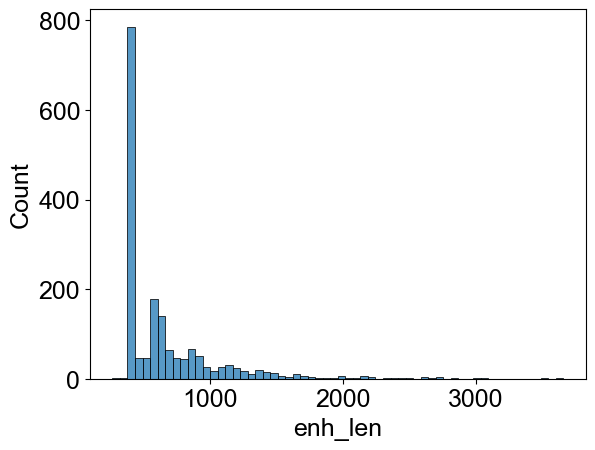

In [22]:
data=genomic[["enh.name", "enh_len"]].drop_duplicates().copy()
x="enh_len"
sns.histplot(x=x, data=data)

## number of tiles per enhancer

        tile.count
count  1740.000000
mean     24.239080
std      24.511355
min       1.000000
25%       9.000000
50%      18.000000
75%      27.000000
max     222.000000


<Axes: xlabel='tile.count', ylabel='Count'>

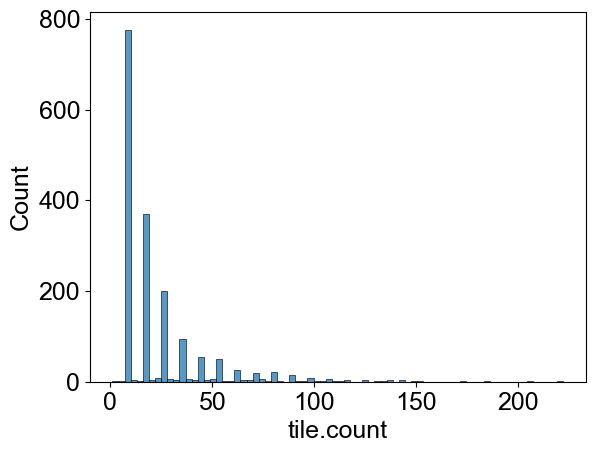

In [23]:
data=genomic.groupby(["enh.name"])["name"].count().reset_index().sort_values(by="name").rename(columns={"name":"tile.count"})
print(data.describe())
x="tile.count"
sns.histplot(x=x, data=data)

## the number of tiles tested is strongly correlated with enhancer length. 

             enh_len  tile_count
enh_len     1.000000    0.907298
tile_count  0.907298    1.000000


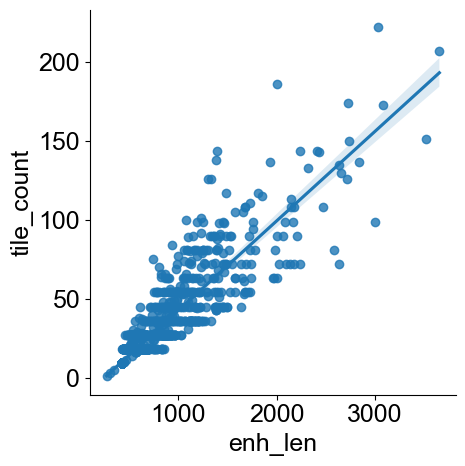

In [24]:
data=genomic.groupby(["enh.name", "enh_len"])["name"].count().reset_index().rename(columns={"name":"tile_count"}).copy()

x="enh_len"
y="tile_count"
sns.lmplot(x=x, y=y, data=data)
print(data[[x,y]].corr())

# Active loci only 

## relaxed

In [28]:
# get sequences that have some evidence of activity. No shuffles
# doesn't include support criteria-just need one tile to be considered active

active = genomic.loc[(genomic["gaba-label"] != "False") |
                     (genomic["glut-label"] != "False"),
                     ["gaba-label", "glut-label", "enh.name", "enh_len", "celltype_dif"]].dropna().copy().drop_duplicates()

In [44]:
# number of enhancer loci with activity in either
len(active["enh.name"].unique())

1166

In [29]:
1168/1829 # with shuffles included

0.6386003280481137

In [48]:
1166/1741 #without shuffles, positive controls, neg controls, synthetics

0.6697300402067777

In [96]:
active["sum"] = active["gaba-label"] +"," +active["glut-label"] 
active

,gaba-label,glut-label,enh.name,enh_len,celltype_dif,sum
78,silencing,silencing,enh.4,588.0,False,"silencing,silencing"
93,False,activating,enh.5,430.0,True,"False,activating"
102,activating,False,enh.6,553.0,True,"activating,False"
105,False,activating,enh.6,553.0,True,"False,activating"
122,activating,activating,enh.6,553.0,False,"activating,activating"
...,...,...,...,...,...,...
43924,False,activating,enh.1823,2471.0,True,"False,activating"
43942,activating,False,enh.1823,2471.0,True,"activating,False"
43967,False,activating,enh.1824,591.0,True,"False,activating"
44002,False,activating,enh.1825,1573.0,True,"False,activating"


## strict - support required

In [61]:
# tiles with support ()
active_s = genomic.loc[(genomic["enh.name"].isin(supported_enhid)), 
                     [ "enh.name", "enh_len"]].dropna().copy().drop_duplicates()

# add gaba, glut support annotations
active_s = pd.merge(active_s , 
                    support[["enh.name", "neighbor_gaba_label", "neighbor_glut_label", "neighbor_either_label"]], 
                    how="left").drop_duplicates()

## strict Subregional activity: how many elements have more than 1 cell neighbor_either_label label?

In [63]:
a = active_s.groupby(["enh.name"])["neighbor_either_label"].sum().reset_index()#.groupby("celltype_dif").unique()#["enh.name"].count()
print(a.head(15))
# >1 annotation, multiple active neighborhoods in different cell types
# if 1 annotation that locus has cell-type-specific activity in one cell type
# if 1 annotation is False, that locus has conserved activity across both cell types. 
a.sort_values(by="neighbor_either_label").groupby("neighbor_either_label").count()

    enh.name  neighbor_either_label
0     enh.10                      1
1   enh.1001                      1
2   enh.1003                      1
3   enh.1004                      1
4   enh.1005                      1
5   enh.1006                      1
6   enh.1012                      1
7   enh.1015                      2
8   enh.1017                      1
9   enh.1018                      1
10  enh.1020                      3
11  enh.1023                      2
12  enh.1024                      1
13  enh.1026                      1
14  enh.1027                      1


,enh.name
neighbor_either_label,
1,525
2,60
3,52


## 

In [71]:
for i in np.arange(1,4):
    print(a.loc[a["neighbor_either_label"]==i].head())

multi_support = a.loc[a["neighbor_either_label"]>1, "enh.name"]
multi_support

   enh.name  neighbor_either_label
0    enh.10                      1
1  enh.1001                      1
2  enh.1003                      1
3  enh.1004                      1
4  enh.1005                      1
    enh.name  neighbor_either_label
7   enh.1015                      2
11  enh.1023                      2
18  enh.1034                      2
20  enh.1041                      2
28  enh.1061                      2
    enh.name  neighbor_either_label
10  enh.1020                      3
22  enh.1045                      3
25  enh.1051                      3
32  enh.1077                      3
36  enh.1083                      3


7      enh.1015
10     enh.1020
11     enh.1023
18     enh.1034
20     enh.1041
         ...   
611     enh.920
612     enh.922
618     enh.933
620     enh.936
629     enh.966
Name: enh.name, Length: 112, dtype: object

In [67]:
for enh in ["enh.10", "enh.1015",  "enh.1020",]:  # 1 true neighbor_either_label, 2 tru neighbor_either_label, 3 true neighbor_either_label
    print(enh, active_s.loc[active_s['enh.name']==enh].drop_duplicates(), "\n\n")

enh.10    enh.name  enh_len  neighbor_gaba_label  neighbor_glut_label  \
27   enh.10    430.0                False                 True   
35   enh.10    430.0                False                False   

    neighbor_either_label  
27                   True  
35                  False   


enh.1015        enh.name  enh_len  neighbor_gaba_label  neighbor_glut_label  \
12299  enh.1015    859.0                False                False   
12316  enh.1015    859.0                False                 True   
12318  enh.1015    859.0                 True                 True   

       neighbor_either_label  
12299                  False  
12316                   True  
12318                   True   


enh.1020        enh.name  enh_len  neighbor_gaba_label  neighbor_glut_label  \
12353  enh.1020   2150.0                False                False   
12404  enh.1020   2150.0                False                 True   
12411  enh.1020   2150.0                 True                 True   
1

In [70]:
112/637

0.17582417582417584

## Relaxed Subregional activity: how many elements have more than 1 cell type_dif label?

In [97]:
a = active.groupby(["enh.name"])["celltype_dif"].sum().reset_index()#.groupby("celltype_dif").unique()#["enh.name"].count()
print(a.head())
# >1 annotation, multiple activities across different tiles
# if 1 annotation is True, that locus has cell-type-specific activity in one cell type
# if 1 annotation is False, that locus has conserved activity across both cell types. 
a.sort_values(by="celltype_dif").groupby("celltype_dif").count()

   enh.name celltype_dif
0    enh.10            2
1   enh.100        False
2  enh.1000         True
3  enh.1001            2
4  enh.1003         True


,enh.name
celltype_dif,
False,26
True,860
2,238
3,34
4,8


### how many loci show subregional activity differences?
- subregional N=280/ 1166 active loci
- cell-type-specific only N=860/1166 active loci
- consistent activity across tiles in both elements N=26/1166
##### most loci with regulatory activity in both cell types have sub-regional, cell-type-specific activity


In [99]:
(238+34+8), (238+34+8)/1166, 860/1166, 26/1166  # percent of elements with more than 1 activity label, percent of elements with only one activity label

(280, 0.24013722126929674, 0.7375643224699828, 0.022298456260720412)

## sanity check for subregional annotations

     enh.name celltype_dif
    0    enh.10            2  # both true and false celltype_dif in activity
    1   enh.100        False  # conserved activity in both cell types
    2  enh.1000         True  # cell type specific activity 
    3  enh.1001            2  # both true and false celltype_dif in activity
    4  enh.1003         True  # cell type specific activity 

In [78]:
def group2Model(group_str, tf):
    """report the models aggregated in each archetype"""
    group_mapping = tf.loc[(tf["group"].str.contains(group_str)) &
                           (~tf["group"].isna())].groupby("group")["model"].unique().reset_index()


    for i in np.arange(group_mapping.shape[0]):
        print(group_mapping.iloc[i]["group"])
        print(group_mapping.iloc[i]["model"])

In [98]:
for enh in ["enh.10", "enh.100", "enh.1000", "enh.1001", "enh.1003"]:
    print(enh, active.loc[active['enh.name']==enh], "\n\n")

enh.10     gaba-label  glut-label enh.name  enh_len celltype_dif  \
190      False  activating   enh.10    430.0         True   
192  silencing  activating   enh.10    430.0         True   

                      sum  
190      False,activating  
192  silencing,activating   


enh.100      gaba-label glut-label enh.name  enh_len celltype_dif                  sum
2627  silencing  silencing  enh.100    931.0        False  silencing,silencing 


enh.1000       gaba-label  glut-label  enh.name  enh_len celltype_dif               sum
24755      False  activating  enh.1000    430.0         True  False,activating 


enh.1001        gaba-label  glut-label  enh.name  enh_len celltype_dif  \
24774  activating       False  enh.1001   1378.0         True   
24822       False  activating  enh.1001   1378.0         True   

                    sum  
24774  activating,False  
24822  False,activating   


enh.1003       gaba-label  glut-label  enh.name  enh_len celltype_dif               sum
24846    

# how many loci have cell-specific activity?

## investigate RFX types

In [102]:
for celltype in ["gaba", "glut"]:
    print(celltype, active.loc[active[f"{celltype}-label"]!="False", "enh.name"].drop_duplicates().shape[0])

gaba 559
glut 1091


In [79]:
group2Model("RFX", tf)

RFX/1
['RFX1_HUMAN.H11MO.0.B' 'RFX2_MOUSE.H11MO.0.A' 'RFX3_MOUSE.H11MO.0.C'
 'Rfx3.mouse_RFX_1' 'RFX2_HUMAN.H11MO.0.A' 'RFX3_HUMAN.H11MO.0.B'
 'RFX5_RFX_2' 'Rfx2.mouse_RFX_1' 'RFX5_MA0510.2' 'Rfx1_MA0509.1'
 'RFX4_MA0799.1' 'RFX3_MA0798.1' 'RFX2_MA0600.2']
RFX/2
['RFX3_RFX_2' 'Rfx2.mouse_RFX_2' 'RFX4_RFX_2' 'RFX2_RFX_2']
RFX/3
['RFX5_HUMAN.H11MO.0.A']


In [83]:
group2Model("NFY", tf)

NFY
['NFYB_HUMAN.H11MO.0.A' 'NFYC_MOUSE.H11MO.0.B' 'NFYB_MA0502.1'
 'NFYA_HUMAN.H11MO.0.A' 'FOXI1_HUMAN.H11MO.0.B' 'PBX3_MOUSE.H11MO.0.A']


In [86]:
group2Model("POU", tf)

POU/1
['POU2F2_MA0507.1' 'Pou2f3_MA0627.1' 'POU3F3_MA0788.1'
 'Pou2f2.mouse_POU_2' 'PO2F1_HUMAN.H11MO.0.C' 'POU1F1_MA0784.1']
POU/2
['POU4F3_MA0791.1' 'POU3F3_POU_2' 'POU4F2_MA0683.1' 'POU4F1_MA0790.1'
 'POU4F2_POU_1' 'POU3F4_POU_2']
POU/3
['PO3F2_MOUSE.H11MO.0.A' 'POU5F1P1_POU_2' 'POU2F1_POU_2'
 'PO3F2_HUMAN.H11MO.0.A' 'Pou2f2.mouse_POU_1' 'PO3F1_MOUSE.H11MO.0.C']
